In [ ]:
print("shree"*10)

# Context


It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

# Content


The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


# Inspiration

Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

# Acknowledgement

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import sklearn
import scipy
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [2]:
RANDOM_SEED = 42
LABELS = ['Normal','Fraud']

In [6]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
data.isnull().values.any()

False

In [8]:
count_classes = pd.value_counts(data['Class'],sort = True)

In [9]:
count_classes

0    284315
1       492
Name: Class, dtype: int64

Text(0, 0.5, 'Frequency')

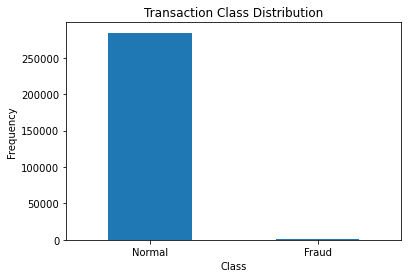

In [10]:
count_classes.plot(kind='bar',rot=0)
plt.title('Transaction Class Distribution')
plt.xticks(range(2),LABELS)
plt.xlabel('Class')
plt.ylabel('Frequency')

In [11]:
#Get "Fraud" and "Normal" Dataset
fraud = data[data['Class'] == 1]

normal = data[data['Class'] == 0]

In [12]:
print('Fraud',fraud.shape, 'Normal:',normal.shape)

Fraud (492, 31) Normal: (284315, 31)


In [13]:
#Take sample of data
data_1 = data.sample(frac=0.1,random_state=0)

In [14]:
data_1.shape

(28481, 31)

In [15]:
Fraud = data_1[data_1['Class'] == 1]

Valid = data_1[data_1['Class'] == 0]

In [16]:
print(Fraud.shape,Valid.shape)

(55, 31) (28426, 31)


In [17]:
outlier_fraction = len(Fraud) / float(len(Valid))
outlier_fraction

0.0019348483782452685

In [18]:
#HeatMap
#plt.figure(figsize=(20,20))
#sns.heatmap(data[data_1.corr().index],annot=True)
#plt.show()


In [19]:
columns = data_1.columns.tolist()
columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [20]:
columns = [c for c in columns if c not in ['Class']]
X = data_1[columns]

In [21]:
y = data_1['Class']

In [22]:
print(X.shape,y.shape)

(28481, 30) (28481,)


# Model Prediction

Now it is time to start building the model .The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows

# Isolation Forest Algorithm:


One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work
The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

# Local Outlier Factor(LOF) Algorithm:

The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [23]:
#Define the Outlier Detection Methods

state = np.random.RandomState(42)

classifiers = {
"Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X),
contamination=outlier_fraction,random_state= state, verbose=0),
"Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto',
leaf_size=30, metric='minkowski',
p=2, metric_params=None, contamination=outlier_fraction),
"Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05,
max_iter=-1)
}

In [24]:
state

RandomState(MT19937) at 0x1A6500BA540

In [25]:
n_outlier = len(Fraud) 
n_outlier

55

In [30]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
        
    elif clf_name == 'Isolation Forest':
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    else:
        clf.fit(X)
        y_pred = clf.predict(X)
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1]= 1
    n_errors = (y_pred!=y).sum()
    print('{}:{}'.format(clf_name,n_errors))
    print('Accuracy Score:')
    print(accuracy_score(y,y_pred))
    print("Classification Report:")
    print(classification_report(y,y_pred))

Isolation Forest:73
Accuracy Score:
0.9974368877497279
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28426
           1       0.34      0.35      0.34        55

    accuracy                           1.00     28481
   macro avg       0.67      0.67      0.67     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor:109
Accuracy Score:
0.9961728871879498
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28426
           1       0.02      0.02      0.02        55

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

Support Vector Machine:8763
Accuracy Score:
0.6923211965871985
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.69      0.82 